In [1]:
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sbn
import numpy as np 

import torch

import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import r2_score
from sklearn.metrics import silhouette_score, silhouette_samples
import umap
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

from amlvae.models.VAE import VAE 
from amlvae.train.Trainer import Trainer

from amlvae.data.ExprProcessor import ExprProcessor
from amlvae.data.ClinProcessor import ClinProcessor

from sklearn.model_selection import KFold

from sklearn.metrics import pairwise_distances

import torch

from torch.nn import TransformerEncoder, TransformerEncoderLayer


# auto reimport 
%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
expr_long = pd.read_csv('../../data/aml_train.csv')
clin = pd.read_csv('../../data/beataml_clinical_for_inputs.csv')
eproc = ExprProcessor(expr_long, target='fpkm_unstranded', norm='zscore_log2', top_genes=2500)
cproc = ClinProcessor(clin.set_index('gdc_id'), targets=['specimenType', 'consensus_sex', 'reportedRace'])
# cohort (waves 1+2, waves 3+4)

In [3]:
X_train, train_ids = eproc.get_data()
X_train = torch.tensor(X_train, dtype=torch.float32)

cond_train = cproc.get_data(train_ids)
cond_meta = {targ: cond_train[targ].shape[1] for targ in cond_train}
cond_train = {targ: torch.tensor(cond_train[targ].argmax(1), dtype=torch.long).view(-1) for targ in cond_train}

In [ ]:
X_val, val_ids = eproc.process_new(pd.read_csv('../../data/aml_validation.csv'))
X_val = torch.tensor(X_val, dtype=torch.float32)

In [5]:
X_test, test_ids = eproc.process_new(pd.read_csv('../../data/aml_test.csv'))
X_test = torch.tensor(X_test, dtype=torch.float32)

In [24]:
class AmlDataset(torch.utils.data.Dataset):
    def __init__(self, X, gene_names, vocab, min_expr=-5, max_expr=5, n_bins=20):
        self.X = X
        self.gene_names = gene_names
        self.vocab = vocab
        self.token2idx = {t: i for i, t in enumerate(vocab)}
        self.min_expr = min_expr
        self.max_expr = max_expr
        self.n_bins = n_bins 

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        
        x = self.X[idx]
        tokens = self.gene_names.tolist() + ['<cls>']
        seq = torch.tensor([self.token2idx[t] for t in tokens], dtype=torch.long)
        expr_bins = torch.bucketize(x, torch.linspace(self.min_expr, self.max_expr, self.n_bins))

        expr_bins = torch.cat([expr_bins, torch.tensor([0], dtype=torch.long)])
        
        return seq, expr_bins

In [25]:

class MLP(torch.nn.Module): 

    def __init__(self, in_channels, hidden_channels, out_channels, layers=2, dropout=0, 
                        nonlin=torch.nn.ELU, out=None, norm=torch.nn.LayerNorm): 
        '''
        
        Args: 
            in_channels             int                 number of input channels 
            hidden_channels         int                 number of hidden channels per layer 
            out_channels            int                 number of output channels 
            layers                  int                 number of hidden layers 
            dropout                 float               dropout regularization probability 
            nonlin                  pytorch.module      non-linear activation function 
            out                     pytorch.module      output transformation to be applied 
            norm                    pytorch.module      normalization method to use 
        '''
        super().__init__()
        
        seq = [torch.nn.Linear(in_channels, hidden_channels)]
        if norm is not None: seq.append(norm(hidden_channels))
        seq += [nonlin(), torch.nn.Dropout(dropout)] 
        for _ in range(layers - 1): 
            seq += [torch.nn.Linear(hidden_channels, hidden_channels)]
            if norm is not None: seq.append(norm(hidden_channels))
            seq += [nonlin(), torch.nn.Dropout(dropout)]
        seq += [torch.nn.Linear(hidden_channels, out_channels)]
        if out is not None: seq += [out()]

        self.mlp = torch.nn.Sequential(*seq)

    def forward(self, x): 

        return self.mlp(x)
       

In [ ]:

class exprGPT(nn.Module):
    def __init__(self, vocab, d_model=128, n_heads=4, n_layers=2, dropout=0.1, n_expr_bins=20):
        """
        Args:
            vocab: A dictionary or list mapping tokens to indices.
            d_model: Embedding dimension.
            n_heads: Number of attention heads.
            n_layers: Number of Transformer encoder layers.
            dropout: Dropout probability.
        """
        super().__init__()
        assert d_model % 2 == 0, "d_model must be even."
        self.d_model = d_model
        self.vocab = vocab
        self.vocab_size = len(vocab)
        
        self.pad_idx = self.vocab.tolist().index('<pad>')
        
        # Embedding layer for tokens.
        self.emb = nn.Embedding(self.vocab_size, d_model, padding_idx=self.pad_idx)
        self.xemb = nn.Embedding(n_expr_bins + 1, d_model)

        self.dropout = torch.nn.Dropout(dropout)

        # Build the transformer encoder.
        encoder_layer = TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_heads, 
            dim_feedforward=4 * d_model, 
            activation = 'gelu', 
            dropout=dropout,
            batch_first=True
        )

        self.encoder = TransformerEncoder(encoder_layer, num_layers=n_layers)
        self.embx_ln = nn.LayerNorm(d_model)
        self.head_ln = nn.LayerNorm(d_model)

        self.head_gene = MLP(d_model, d_model, n_expr_bins + 1, 2, dropout)

        # Initialize weights.
        self.init_weights()

    def init_weights(self, std=0.02):
        """
        GPT-style initialization:
          - Normal(0, 0.02) for all weights (Embedding + Linear)
          - Biases set to 0 (if present)
        """
        def _init(module):
            if isinstance(module, nn.Embedding):
                nn.init.normal_(module.weight, mean=0.0, std=std)
                # If you have a padding_idx, you can zero out that row if you want:
                # if module.padding_idx is not None:
                #     with torch.no_grad():
                #         module.weight[module.padding_idx].fill_(0)
            elif isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=std)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0)

        # Recursively apply the initialization to every sub-module
        self.apply(_init)
    
    def encode(self, seq, expr): 

        x1 = self.dropout(self.emb(seq))  # (B, seqlen, d_model)
        x2 = self.dropout(self.xemb(expr))  # (B, seqlen, d_model)
        x = x1 + x2  # (B, seqlen, d_model)
        x = self.embx_ln(x)
        
        # Pass through the transformer encoder.
        x = self.encoder(x)  # (seqlen, B, d_model)
        x = self.head_ln(x)
        return x 
    
    def forward(self, seq, expr, mask=None) -> torch.Tensor:
        """
        Args:
            seq: Tensor of shape (B, seqlen) containing token indices.
        Returns:
            logits: Tensor of shape (B, seqlen, vocab_size).
        """
        x = self.encode(seq, expr, mask)
        logits_gene = self.head_gene(x)  # (B, seqlen, vocab_size)

        return logits_gene

In [12]:
torch.cuda.empty_cache()

In [ ]:
gene_names = eproc.gene_names
vocab = np.array( gene_names.tolist() + ['<cls>', '<pad>', '<mask>'] )

train_dataset = AmlDataset(X_train, gene_names, vocab, mask_prob=0.5)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = AmlDataset(X_val, gene_names, vocab, mask_prob=0.5)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = exprGPT(vocab, d_model=32, n_heads=4, n_layers=6, dropout=0.1, n_expr_bins=20).to(device)
crit = torch.nn.CrossEntropyLoss()
optim = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

In [23]:
for epoch in range(10):

    model.train() 
    losses = 0
    for seq, expr, mask in train_loader: 
        seq = seq.to(device); expr = expr.to(device); mask = mask.to(device)
        optim.zero_grad()
        logits = model(seq, expr, mask)
        logits = logits[mask, :].contiguous().view(-1, logits.shape[-1])
        targets = expr[mask].contiguous().view(-1)
        loss = crit(logits, targets)
        loss.backward()
        optim.step()
        losses += loss.item()
        print(f'[batch loss: {loss.item():.2f}]', end='\r')

    losses /= len(train_loader)

    print(f"-------> Epoch {epoch+1}, Loss: {losses:.4f}")

-------> Epoch 1, Loss: 0.2587


KeyboardInterrupt: 

In [19]:
t2_dataset = AmlDataset(X_train, gene_names, vocab, mask_prob=0)
t2_loader = torch.utils.data.DataLoader(t2_dataset, batch_size=64, shuffle=False)

In [20]:
clss = [] 
model.eval()
for seq, expr, mask in t2_loader:
    
    seq = seq.to(device); expr = expr.to(device); mask = mask.to(device)
    with torch.no_grad():
        z = model.encode(seq, expr, mask)
        z = z[:, -1, :].cpu().numpy()
        clss.append(z)

clss = np.concatenate(clss, axis=0)

/home/teddy/miniconda3/envs/amlvae/lib/python3.12/site-packages/torch/nn/modules/transformer.py:502: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647378361/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(


In [21]:
#reducer = umap.UMAP(n_neighbors=10, min_dist=0.5, n_components=2, metric='cosine', random_state=42)
reducer = PCA(n_components=2)
u = reducer.fit_transform(clss)

df = pd.DataFrame(u, columns=['u1', 'u2']).assign(gdc_id=train_ids)
df = df.merge(clin, on='gdc_id', how='left')

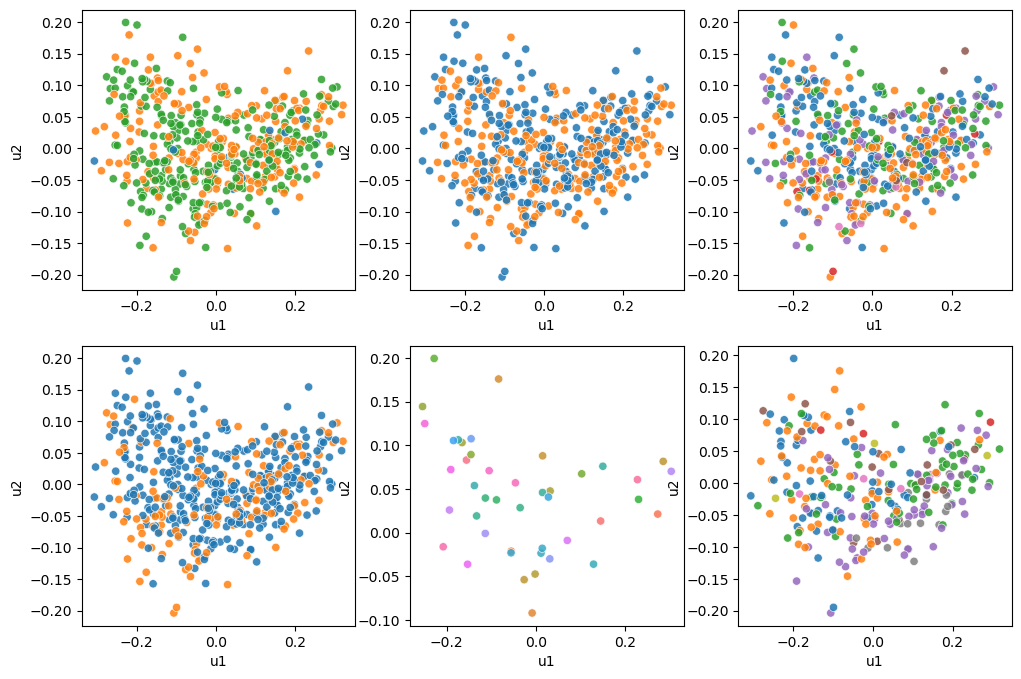

In [22]:
f,axes = plt.subplots(2,3, figsize=(12,8))
sbn.scatterplot(data=df, x='u1', y='u2', hue='specimenType', ax=axes.flatten()[0], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='consensus_sex', ax=axes.flatten()[1], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='ELN2017', ax=axes.flatten()[2], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='NPM1', ax=axes.flatten()[3], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='TP53', ax=axes.flatten()[4], legend=False, alpha=0.85, linewidth=0.5)
sbn.scatterplot(data=df, x='u1', y='u2', hue='fabBlastMorphology', ax=axes.flatten()[5], legend=False, alpha=0.85, linewidth=0.5)
plt.show()